In this notebook we show how to get all the temperature measurements and quality flags (QF) acquired by the mooring located in the Palma Bay (_Bahía de Palma_).

In [22]:
using JSON
using HTTP
using Dates
using NCDatasets

## Request
### API key
In order to avoid hard-coding the key in the notebook, you can create a new environment variable in a terminal:
```bash
export socib_api_key=your_api_key
```
Then the variable can be accessed in Julia using 
```julia
ENV["socib_api_key"]
```

### Build the query

In [2]:
api_key = ENV["socib_api_key"]
query1 = "http://api.socib.es/entries/?page_size=100&processing_level=L1&instrument_type=Conductivity%20and%20Temperature%20Recorder&platform=Buoy_BahiaDePalma&apikey=$(api_key)&page=1"
query2 = "http://api.socib.es/entries/?page_size=100&processing_level=L1&instrument_type=Conductivity%20and%20Temperature%20Recorder&platform=Buoy_BahiaDePalma&apikey=$(api_key)&page=2"
r1 = HTTP.request("GET", query1);
r2 = HTTP.request("GET", query2);

### Convert responses to dictionaries 
using the `JSON`module.

In [3]:
r1dict = JSON.parse(String(r1.body));
r2dict = JSON.parse(String(r2.body));
@info("Found a total of $(length(r1dict["results"])) + $(length(r2dict["results"])) entries")

┌ Info: Found a total of 100 + 15 entries
└ @ Main In[3]:3


### Build a list of URLs (OPEnDAP) 

In [23]:
urllist = String[]
for r in r1dict["results"]
    push!(urllist, r["services"]["opendap"]["url"])
end
for r in r2dict["results"]
    push!(urllist, r["services"]["opendap"]["url"])
end
@info(length(urllist));

┌ Info: 115
└ @ Main In[23]:8


## Data reading
### Functions

We create two functions for:
1. reading the time series from a single time period (one OPeNDAP URL)
2. reading all the time series (in one go) from the full period (2012-2012, list of OPeNDAP URLs)

In [18]:
function read_temperature(dataurl::String)
    NCDatasets.Dataset(dataurl, "r") do ds
        time = NCDatasets.varbyattrib(ds, standard_name="time")[1][:]
        T = NCDatasets.varbyattrib(ds, standard_name="sea_water_temperature")[1][:]
        TQF = NCDatasets.varbyattrib(ds, standard_name="sea_water_temperature status_flag")[1][:]
        return coalesce.(time, NaN)::Vector{Dates.DateTime}, coalesce.(T, NaN)::Vector{Float64}, 
        coalesce.(TQF, NaN)::Vector{Int8}
    end
end

read_temperature (generic function with 2 methods)

In [19]:
function read_temperature(urllist::Array{String})
    datesall = Dates.DateTime[];
    Tall = Float64[]
    TQFall = Int8[]
    
    for dataurl in urllist
        dates, T, TQF = read_temperature(dataurl);
        append!(datesall, dates)
        append!(Tall, T)
        append!(TQFall, TQF)
    end
    
    return datesall, Tall, TQFall
end

read_temperature (generic function with 2 methods)

### Reading
The function is applied to the list we build in a previous step.

In [24]:
@time dates, T, TQF = read_temperature(urllist);

 60.778293 seconds (1.58 M allocations: 246.938 MiB, 0.19% gc time)


Keep only data points which have QF = 1

In [38]:
T[TQF .!= 1] .= NaN;

16531-element view(::Vector{Float64}, [1093, 1183, 4962, 4963, 4964, 4965, 4966, 4967, 6767, 7787  …  98371, 98374, 98388, 98406, 98413, 98418, 98423, 98433, 98439, 98442]) with eltype Float64:
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
   ⋮
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN

## Plotting

We use `PyPlot`, based on Python `matplotlib`.

In [30]:
using PyPlot
const plt = PyPlot

LoadError: cannot assign a value to variable PyPlot.plt from module Main

If needed, specify the path of the Python you are using
```bash
ENV["PYTHON"] = "/usr/local/bin/python3.8"
```

In [31]:
using PyCall
mdates = pyimport("matplotlib.dates")

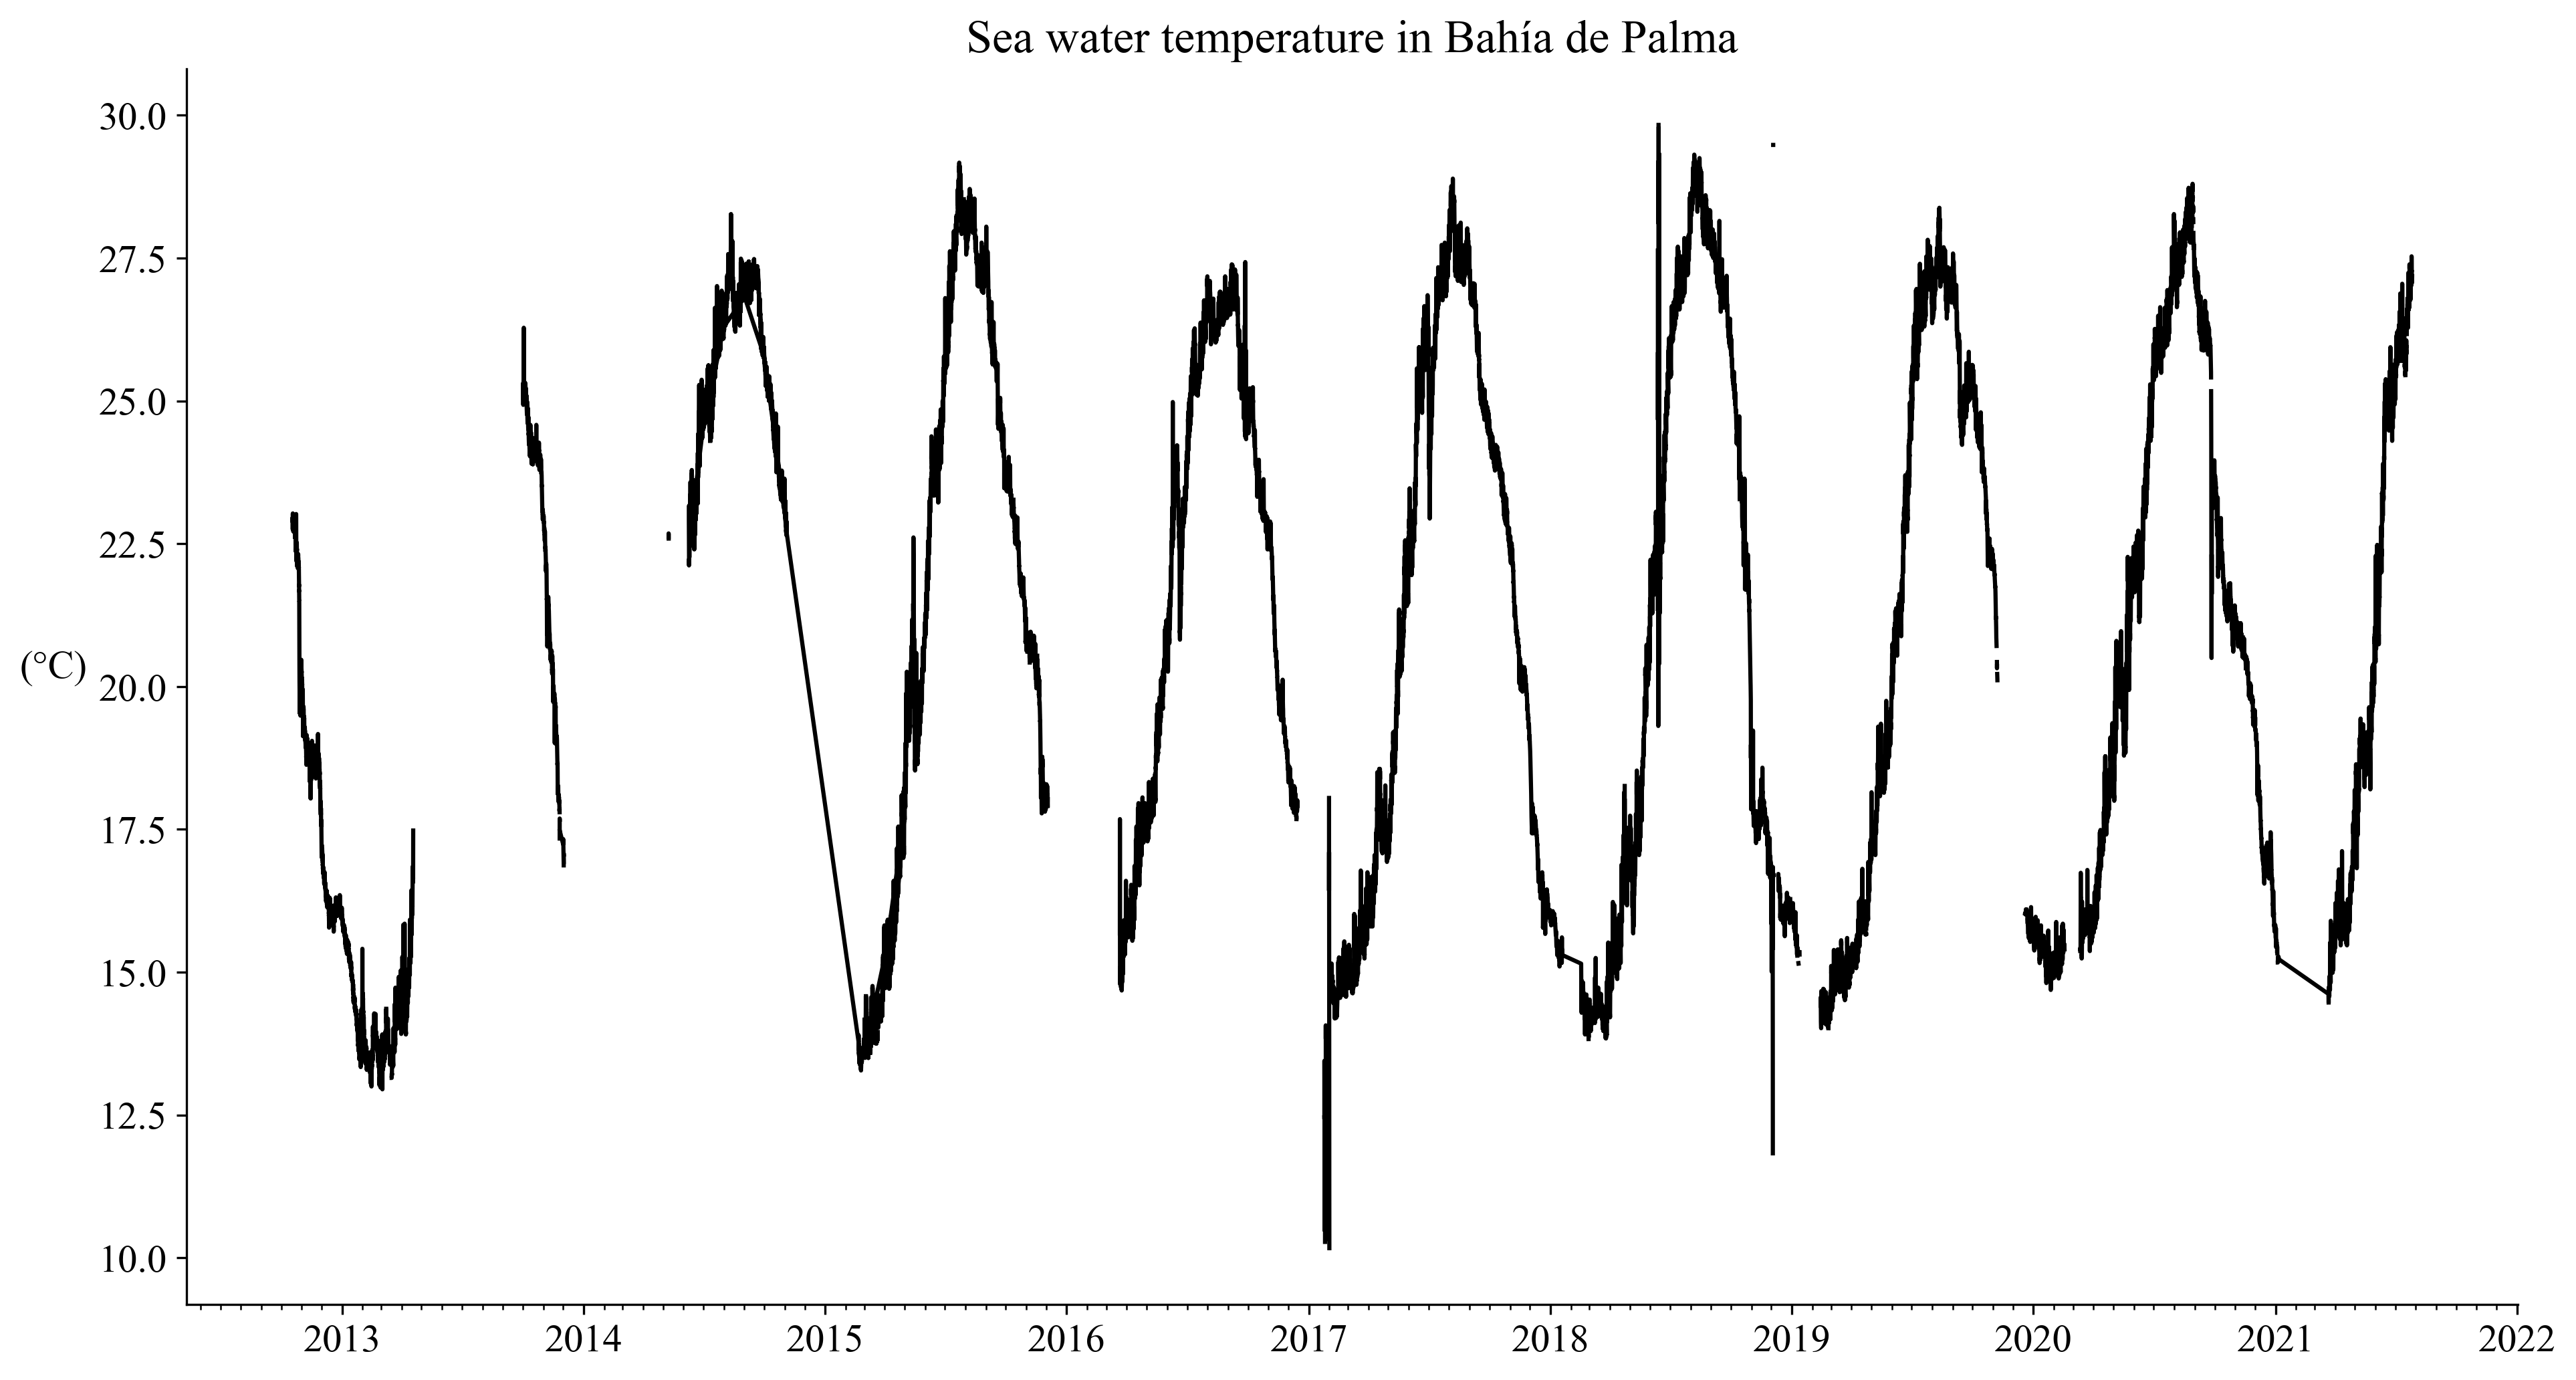

In [40]:
fig = plt.figure(figsize=(15, 8))
ax = plt.subplot(111)
ax.plot(dates, T, color="k")
plt.title("Sea water temperature in Bahía de Palma", ha="center", rotation=0)
plt.ylabel("(°C)", ha="right", rotation=0)
ax.spines["right"].set_visible(false)
ax.spines["top"].set_visible(false)
fmt_month = mdates.MonthLocator()
ax.xaxis.set_minor_locator(fmt_month)
# plt.savefig("./temperature_bahia_V2.jpg", dpi=300, bbox_inches="tight")
plt.show()
# plt.close()